In [2]:
# basic
import numpy as np
import pandas as pd

# gnn and train
import tensorflow as tf
import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import gat_v2, graph_sage

# demo
import matplotlib.pyplot as plt

2022-12-15 07:01:16.569237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 07:01:16.711699: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 07:01:16.716207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 07:01:16.716224: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
record_fp = './tfgnn_dataset/nexmark_isBP.tfrecord'
schema_fp = './tfgnn_dataset/schema_poc.pbtxt'

In [10]:
# Read the dataset of tf.Example protos for training.
dataset = tf.data.TFRecordDataset(filenames=[record_fp])
# dataset = ...  # Shuffle, repeat and prefetch as appropriate. TODO
dataset = dataset.shuffle(buffer_size=10000, seed=8888)

# print(dataset)

dataset = dataset.batch(10)  # Expected before preprocessing.

In [11]:
# Parse the GraphTensor values.
graph_schema = tfgnn.read_schema(schema_fp)
example_input_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema) # spec

dataset = dataset.map(tfgnn.keras.layers.ParseExample(example_input_spec))
# size_constraints = tfgnn.find_tight_size_constraints(dataset, ) # compute the size
dataset = dataset.repeat() # optional

preproc_input_spec = dataset.element_spec
preproc_input_spec

GraphTensorSpec({'context': ContextSpec({'features': {'label_isBP': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'records_input_rate': TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), 'bytes_input_rate': TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'operate': NodeSetSpec({'features': {'records_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'utilization_embedding': RaggedTensorSpec(TensorShape([None, None, 6]), tf.float32, 1, tf.int32), 'bytes_selectivity': RaggedTensorSpec(TensorS

In [12]:
# Define pre-process model for initial hidden states, actually all partial models
def node_sets_fn(node_set, *, node_set_name):
    if node_set_name == 'source':
        return node_set['parallelism']
    elif node_set_name == 'operate':
        print(node_set)
#         stacked_non_embed = tf.stack([node_set['bytes_selectivity'], 
#                                       node_set['records_selectivity'], 
#                                       node_set['parallelism']], axis=2)
        stacked_non_embed = tf.keras.layers.Concatenate()([node_set['bytes_selectivity'], 
                                                          node_set['records_selectivity'], 
                                                            node_set['parallelism']])
        print('stacked_non_embed:', stacked_non_embed)
        return tf.keras.layers.Concatenate()([ 
            node_set['utilization_embedding'],
            stacked_non_embed,
            ])

# def edge_sets_fn(): TODO

def context_fn(context):
#     stacked_cont = tf.stack([context['bytes_input_rate'], 
#                     context['records_input_rate'],], axis=2)
    stacked_cont = tf.keras.layers.Concatenate()([context['bytes_input_rate'], 
                                                  context['records_input_rate'],],)
    return {'hidden_state': stacked_cont,
            'label_isBP': context['label_isBP']}

def split_fn(graph):
    labels = tfgnn.keras.layers.Readout(from_context=True,
                                    feature_name="label_isBP")(graph)
    graph = graph.remove_features(context=['label_isBP'])
    assert "label_isBP" not in graph.context.features
    return graph, labels

In [14]:
# Define and apply the preprocessing model. (now starts to define a graph model with the view of a scalar sample)
preproc_input = tf.keras.layers.Input(type_spec=preproc_input_spec)
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn,
                                      context_fn=context_fn,
                                      )(preproc_input)  # With preprocessed features, see below.
graph = graph.merge_batch_to_components()  # See section "Merging a batch".

# graph, mask = tfgnn.keras.layers.PadToTotalSizes(size_constraints)(graph) # pad
graph, labels = split_fn(graph) # See section "Splitting the label off ...".

# preproc_model = tf.keras.Model(preproc_input, (graph, labels, mask)) # now we defined the pp-model
preproc_model = tf.keras.Model(preproc_input, (graph, labels, )) # now we defined the pp-model

# above is just a defined computing process, the following is the process process on the whole dataset
dataset = dataset.map(preproc_model)

KerasTensor(type_spec=NodeSetSpec({'features': {'records_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'utilization_embedding': RaggedTensorSpec(TensorShape([None, None, 6]), tf.float32, 1, tf.int32), 'bytes_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), description="created by layer 'input_8'")
stacked_non_embed: KerasTensor(type_spec=RaggedTensorSpec(TensorShape([None, None, 3]), tf.float32, 1, tf.int32), description="created by layer 'concatenate_1'")


In [7]:
# ### testing
# DATASET_SIZE = 5460
# train_size = int(0.7 * DATASET_SIZE)
# val_size = int(0.15 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)

# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size)
# test_dataset = test_dataset.take(test_size)

# dataset = train_dataset
# ### end testing

In [15]:
# assert list(graph.node_sets["operate"].keys()) == [tfgnn.HIDDEN_STATE]
# BUG: not working, use manual checking:
list(graph.node_sets['operate'].get_features_dict().keys()),list(graph.node_sets['source'].get_features_dict().keys())

(['hidden_state'], ['hidden_state'])

In [22]:
# define gnn update logic (using gatv2)
def gnn(graph):
    for i in range(2):
        graph = gat_v2.GATv2MPNNGraphUpdate(units=5, message_dim=5, num_heads=1, receiver_tag=tfgnn.SOURCE)(graph)
#         graph = gat_v2.GATv2MPNNGraphUpdate(units=5, message_dim=5, num_heads=1, receiver_tag=tfgnn.SOURCE,)(graph)
    return graph

In [23]:
model_input_spec, _, = dataset.element_spec
model_input_spec

GraphTensorSpec({'context': ContextSpec({'features': {'hidden_state': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'operate': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'src2op': EdgeSetSpec({'features': {}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(None,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 'source', '#index.1': 

In [24]:
# Define and train the main model.
model_input_spec, _, = dataset.element_spec  # Drop the spec for the labels.
model_input = tf.keras.layers.Input(type_spec=model_input_spec)
graph = gnn(model_input) # apply gnn model

# Classifying each graph as a whole, based on an aggregation of the node states from one node set
pooled_features_s = tfgnn.keras.layers.Pool(tfgnn.CONTEXT, "mean", node_set_name="source")(graph)
pooled_features_op = tfgnn.keras.layers.Pool(tfgnn.CONTEXT, "mean", node_set_name="operate")(graph)

pooled_features = tf.keras.layers.concatenate([pooled_features_s, pooled_features_op])

# logits = tf.keras.layers.Dense(1)(pooled_features_op) # output
logits = tf.keras.layers.Dense(1)(pooled_features) # output

model = tf.keras.Model(model_input, logits)

# compile this model for binary classification
model.compile(tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [()]                 0           []                               
                                                                                                  
 graph_update_2 (GraphUpdate)   ()                   280         ['input_10[0][0]']               
                                                                                                  
 graph_update_3 (GraphUpdate)   ()                   240         ['graph_update_2[0][0]']         
                                                                                                  
 pool_2 (Pool)                  (None, 5)            0           ['graph_update_3[0][0]']         
                                                                                            

In [25]:
# train
history = model.fit( dataset,
                     steps_per_epoch=10,
                     epochs=200,)

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'model_2/graph_update_2/node_set_update/gat_v2_conv/GatherV2_1' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4371/2200306830.py", line 2, in <module>
      history = model.fit( dataset,
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/keras/layers/graph_update.py", line 249, in call
      update_fn(graph, node_set_name=node_set_name)))
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/keras/layers/graph_update.py", line 431, in call
      input_from_edge_sets[edge_set_name] = input_fn(
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/keras/layers/convolution_base.py", line 332, in call
      **extra_receiver_ops_kwarg,
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/models/gat_v2/layers.py", line 263, in convolve
      if sender_node_input is not None:
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/models/gat_v2/layers.py", line 264, in convolve
      value_terms.append(broadcast_from_sender_node(
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/keras/layers/convolution_base.py", line 292, in call
      broadcast_from_sender_node = (
    File "/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow_gnn/graph/graph_tensor_ops.py", line 106, in broadcast_node_to_edges
      return tf.gather(node_value, adjacency[node_tag])
Node: 'model_2/graph_update_2/node_set_update/gat_v2_conv/GatherV2_1'
indices[10] = 14 is not in [0, 14)
	 [[{{node model_2/graph_update_2/node_set_update/gat_v2_conv/GatherV2_1}}]] [Op:__inference_train_function_15621]

In [ ]:
# Export the combined SavedModel for serving.
# this part can be waived for current situation..
# serving_input = tf.keras.layers.Input(shape=[],  # The batch dim is implied.
#                                       dtype=tf.string, name="examples")
# preproc_input = tfgnn.keras.layers.ParseExample(example_input_spec)(serving_input)
# serving_model_input, _ = preproc_model(preproc_input)  # Drop labels.
# serving_logits = model(serving_model_input)
# serving_output = {"logits": tf.keras.layers.Layer(name="logits")(serving_logits)}
# exported_model = tf.keras.Model(serving_input, serving_output)
# exported_model.save("/tmp/exported_keras_model", include_optimizer=False)

In [27]:
tf.stack([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

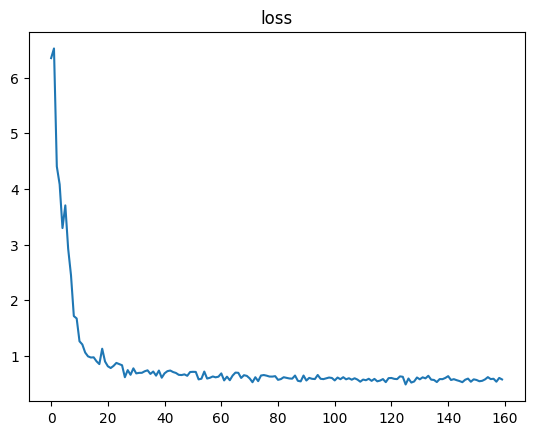

In [82]:
for k, hist in history.history.items():
    plt.plot(hist)
    plt.title(k)
    plt.show()

In [89]:
test_dataset

<TakeDataset element_spec=(GraphTensorSpec({'context': ContextSpec({'features': {'hidden_state': TensorSpec(shape=(11, 2), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(11, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'operate': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(27, 9), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'op2op': EdgeSetSpec({'features': {}, 'sizes': TensorSpec(shape=(11,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(16,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(16,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 'operate', '#i